In [182]:
import pathlib
import sys

import numpy as np
import netCDF4
import colorcet
import cmocean


import matplotlib.patches
import matplotlib.pyplot as plt
import scipy.interpolate
import skimage.draw
import skimage.exposure
import tqdm

local_path = pathlib.Path('~/.local/lib/python3.5/site-packages').expanduser()
sys.path.append(str(local_path))
import cv2

%matplotlib inline


In [40]:
path = pathlib.Path('~/models/c020_pillar/pillar.mdu').expanduser()

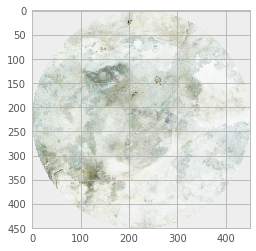

In [69]:
import io
import requests
url = 'http://texturelib.com/Textures/concrete/floor/concrete_floor_0056_01_preview.jpg'
resp = requests.get(url)

bytes = io.BytesIO(resp.content)
concrete = plt.imread(bytes, format='jpg')
concrete = skimage.exposure.adjust_sigmoid(concrete, cutoff=0.4, gain=12)
concrete_rgba = np.dstack([
    concrete[:450, :450].astype('float32')/255.0, 
    np.zeros((450, 450), dtype='float32')
])


r = concrete_rgba.shape[0]/2
rr, cc = skimage.draw.circle(r, r, r, concrete_rgba.shape)
concrete_rgba[rr, cc, 3] = 1.0
plt.imshow(concrete_rgba)


In [119]:
ds = netCDF4.Dataset(path.parent / 'dflowfmoutput' / 'pillar_map.nc')
variables = {}
for var in ['mesh2d_face_x', 'mesh2d_face_y', 'mesh2d_ucx', 'mesh2d_ucy', 'time']:
    variables[var] = ds.variables[var][:]
t_idx = -3
u = variables['mesh2d_ucx'][t_idx]
v = variables['mesh2d_ucy'][t_idx]

# define interpolation function
points = np.c_[variables['mesh2d_face_x'], variables['mesh2d_face_y']]
uv = np.c_[u, v]
r = 1.0
x, y = (0, 1500)
angles = np.linspace(0, np.pi*2, num=1000, endpoint=False)
extra_points = np.c_[np.cos(angles)*r + x, np.sin(angles)*r + y ]
extra_uv = np.zeros_like(extra_points)
points = np.vstack([points, extra_points])
uv = np.vstack([uv, extra_uv])
F = scipy.interpolate.CloughTocher2DInterpolator(
    points,
    uv
)

In [269]:

# loop over t and t+1
def uv_loop(variables, i=0, dt=1.0):
    for t0_idx, (t0, t1) in enumerate(zip(
        variables['time'][i:-1], 
        variables['time'][i+1:]
    )):
        t1_idx = t0_idx + 1
        dt = t1 - t0
        # lookup velocities
        u_0 = variables['mesh2d_ucx'][t0_idx]
        v_0 = variables['mesh2d_ucy'][t0_idx]
        u_1 = variables['mesh2d_ucx'][t1_idx]
        v_1 = variables['mesh2d_ucy'][t1_idx]
        # concatenate 
        uv_0 = np.c_[u_0, v_0]
        # and add extra points
        uv_0 = np.vstack([uv_0, extra_uv])
        uv_1 = np.c_[u_1, v_1]
        uv_1 = np.vstack([uv_1, extra_uv])
        # interpolate
        F.values = uv_0
        UV_0 = F(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape + (2,))
        F.values = uv_1 
        UV_1 = F(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape + (2,))
        # interpolate between two timesteps
        for t_i in np.arange(t0, t1, dt):
            frac = (t_i - t0)/(t1 - t0)
            UV_i = frac * UV_0 + (1-frac) * UV_1
            yield t_i, UV_i 
def img_advect(X, Y, x, y, img, uv, dt, scale=0.1):
    h, w = X.shape
    dy = (y[1] - y[0]) # m/px
    dx = (x[1] - x[0]) # m/px
    flow = uv.astype('float32') * dt
    flow *= scale
    # m/s / m/px -> px/s
    flow[..., 0] /= dx
    flow[..., 1] /= dy
    # lookup originating color for next timestep
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    # adhere to courant condition

    for i in range(50):
        for row in range(10, 590, 50):
            rr, cc = skimage.draw.circle(row, 10, 3, shape=img.shape)
            img[rr, cc] = 1.0
        img = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return img

def make_checkerboard(X, Y):
    blocksize = 2
    img = np.logical_xor(np.mod(Y, blocksize) < blocksize/2, np.mod(X, blocksize) < blocksize/2).astype('float32')
    return img


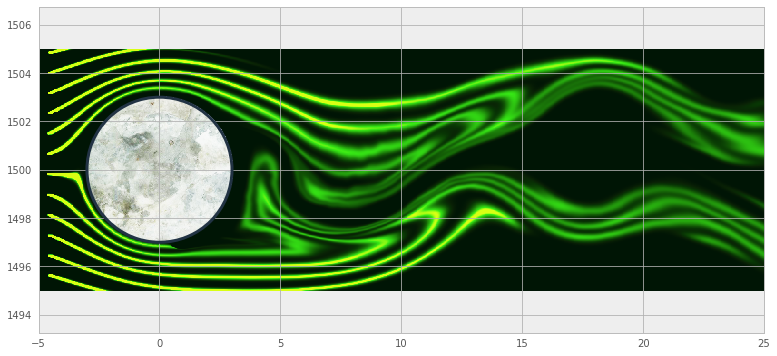

In [276]:

# zoom extent
d = 2.5
# define interpolation grid
Y, X = np.mgrid[1500-2*d:1500+2*d:600j, -2*d:10*d:800j]
y, x = np.ogrid[1500-2*d:1500+2*d:600j, -2*d:10*d:800j]
x = np.squeeze(x)
y = np.squeeze(y)
pole_xy = (0, 1500)
pole_r = 3.0
UV = F(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape + (2,))
# compute circle
circle = matplotlib.patches.Circle(pole_xy, pole_r, facecolor='none', edgecolor='#223344', linewidth=3, zorder=10)
# get the path
circle_path = circle.get_path()
transform = circle.get_transform()
points = np.c_[X.ravel(), Y.ravel()]
# use it to compute the mask
mask = circle_path.contains_points(points, transform=transform).reshape(X.shape)
# set masked velocities to 0
UV[mask] = 0 

fig, ax= plt.subplots(figsize=(13, 6))
# ax.streamplot(
#     x, 
#     y, 
#     UV[..., 0],
#     UV[..., 1], 
#     density=2,
#     linewidth=np.sqrt(UV[..., 0]**2 + UV[..., 1]**2)*3,
#     color='#33445533',
#     minlength=0.1
# )

ax.axis('equal')
# ax.scatter(points[:, 0], points[:,1], c=np.sqrt(uv[:,0]**2 + uv[:, 1]**2))
ax.set_xlim(-d, d*5)
ax.set_ylim(1500-d, 1500+d)
s = np.s_[::30, ::30]
s_x, s_y = np.s_[::30], np.s_[::30]
# ax.pcolormesh(X, Y, np.sqrt(UV[...,0]**2 + UV[...,1]**2), alpha=1.0)
# ax.quiver(X[s], Y[s], UV[..., 0][s], UV[..., 1][s], units='xy')

img = np.random.random(X.shape)
img = np.zeros(X.shape, dtype='float32')

# convert to pixel speed
dt = 1.0 



im = ax.imshow(img, extent=(x.min(), x.max(), y.min(), y.max()), cmap=colorcet.m_kgy, vmin=0, vmax=0.4)
for i, (t_i, uv) in enumerate(uv_loop(variables,i=10, dt=dt)):
    # reseed
    img = img_advect(X, Y, x, y, img, uv, dt)
    im.set_data(img)
    if i > 20:
        break
        
ax.imshow(concrete_rgba, extent=(pole_xy[0] - pole_r, pole_xy[0] + pole_r, pole_xy[1] - pole_r, pole_xy[1] + pole_r))
_ = ax.add_patch(circle)
ax.autoscale()


In [240]:
img.max()

0.0

In [121]:
filter_grid = False
if filter_grid:
    # remove part of the grid
    ds = netCDF4.Dataset(path.with_name('pillar_net.nc'))
    variables = {}
    node_vars = ['NetNode_x', 'NetNode_y', 'NetNode_z', 'NetNode_lat', 'NetNode_lon']
    link_vars = ['NetLink', 'NetLinkType']
    bndlink_vars = ['BndLink']
    elem_vars = ['NetElemNode']

    for var in node_vars:
        # copy data
        variables[var] = ds.variables[var][:]  
    node_selection = np.logical_and(variables['NetNode_y'] >= 1000, variables['NetNode_y'] <= 2000)
    for var in node_vars:
        variables[var] = variables[var][node_selection]


    for var in link_vars:
        variables[var] = ds.variables[var][:]
    # lookup  nodes that are still available
    node_idx_1 = np.where(node_selection)[0] + 1
    # look which links are still available
    from_filter = np.in1d(variables['NetLink'][:, 0], node_idx_1)
    to_filter = np.in1d(variables['NetLink'][:, 1], node_idx_1)
    # assume three grids are not connected
    assert (from_filter == to_filter).all()
    # otherwise we would have to transform into boundary links on removal of link
    link_selection = np.logical_and(from_filter, to_filter)
    for var in link_vars:
        variables[var] = variables[var][link_selection]

    for var in bndlink_vars:
        variables[var] = ds.variables[var][:]
    variables['BndLink']
    bndlink_selection = np.in1d(variables['BndLink'], node_idx_1)
    for var in bndlink_vars:
        variables[var] = variables[var][bndlink_selection]


    for var in elem_vars:
        variables[var] = ds.variables[var][:]
    variables['NetElemNode']
    net_elem_node = np.ma.masked_equal(variables['NetElemNode'], -2147483647)
    elem_selection = np.apply_along_axis(np.ma.in1d, 0, net_elem_node, node_idx_1)
    elem_selection = np.ma.masked_array(elem_selection, mask=net_elem_node.mask)
    # assume all cells are all in, or all out
    assert (elem_selection.all(axis=1) == elem_selection.any(axis=1)).all()
    elem_selection = elem_selection.all(axis=1)
    for var in elem_vars:
        variables[var] = variables[var][elem_selection]

    dims = {
        'nNetNode': node_selection.sum(),
        'nNetLink': link_selection.sum(),
        'nNetLinkPts': 2,
        'nBndLink': bndlink_selection.sum(),
        'nNetElem': elem_selection.sum(),
        'nNetElemMaxNode': 4
    }


    ds_new = netCDF4.Dataset(path.with_name('pillar_new.nc'), mode='w')
    # copy attributes
    for attr in ds.ncattrs():
        ds_new.setncattr(attr, ds.getncattr(attr))
    for dim, length in dims.items():
        ds_new.createDimension(dim, length)
    for name, var in ds.variables.items():
        new_var = ds_new.createVariable(name, var.dtype, var.dimensions)
        for attr in var.ncattrs():
            new_var.setncattr(attr, var.getncattr(attr))

    for name in ds.variables.keys():
        ds_new.variables[name][:] = variables.get(name, ds.variables[name][:])
    ds_new.close()

In [150]:
y[1] - y[0]

0.0701168614357357